<a href="https://colab.research.google.com/github/trappertwo/MdVRNet/blob/main/VRT_on_rPPG_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab is adapted from the VRT Online Demo on Video Restoration (see below for details) to run on compressed UBFC-rPPG data.

It first preprocesses the UBFC rPPG dataset files (compressed using mp4v compression)
- Input needs to be cropped and resized video generated in the preprocessing step in rPPG Toolbox. Frames are cropped after ROI detection using Haar-Cascade face detection and resized to 72 X 72.
- The colab generates .png files for the frames in the video and stores them in the input folder format that the VRT model needs
- Runs the VRT model on the input. Results are stored as .png files in results folder
- Converts the result .png sequence to .mp4 video file and stores it in the output directory on the drive
- The output files can be used for training/inference in rPPG-Toolbox.

# VRT Online Demo on Video Restoration

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2201.12288)
[![GitHub Stars](https://img.shields.io/github/stars/JingyunLiang/VRT?style=social)](https://github.com/JingyunLiang/VRT)
[![download](https://img.shields.io/github/downloads/JingyunLiang/VRT/total.svg)](https://github.com/JingyunLiang/VRT/releases)
![visitors](https://visitor-badge.glitch.me/badge?page_id=jingyunliang/VRT)

This is a **VRT online demo on Video Restoration** of our paper [''VRT: A Video Restoration Transformer''](https://arxiv.org/abs/2201.12288).

VRT ahcieves state-of-the-art performance **(up to 2.16dB)** in
- video SR (REDS, Vimeo90K, Vid4 and UDM10)
- video deblurring (GoPro, DVD and REDS)
- video denoising (DAVIS and Set8)
- video frame interpolation (Vimeo90K, UCF101, DAVIS)
- space-time video SR (Vimeo90K, Vid4)

<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vsr_visual.jpeg" width="100%">
<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vdb_visual.jpeg" width="100%">



# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [ ]:
!rm -r VRT
# Clone VRT
!git clone https://github.com/JingyunLiang/VRT.git
%cd VRT
!pip install -r requirements.txt
!pip install -q mediapy

rm: cannot remove 'VRT': No such file or directory
Cloning into 'VRT'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 99 (delta 21), reused 3 (delta 3), pack-reused 70 (from 1)
Receiving objects: 100% (99/99), 13.06 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/VRT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [57]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive

drive.mount('/content/drive')
# change this to point to the compressed data folder
SOURCE_PATH = '/content/drive/MyDrive/research_project/data/preprocessed/DATASET_150_1_test' # @param {type: "string"}
SUBJECT = 'subject13' # @param{type: "string"}
FILE_NAME = 'vid.mp4' # @param {type: "string"}
!ls -l {SOURCE_PATH}/{SUBJECT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 344
-rw------- 1 root root  95478 Mar  8 03:57 ground_truth.txt
-rw------- 1 root root 255575 Mar  8 03:57 vid.mp4


# 2. Process Videos to be processed by VRT

Read UBFC-rPPG compressed video from drive and store as frames for processing by VRT.

In [58]:
import os
import mediapy as media

path = os.path.join(SOURCE_PATH, SUBJECT, FILE_NAME)
video = media.read_video(path)
media.show_video(video, fps=30)

In [59]:
import os
import glob
from google.colab import files
import shutil
#print(' Note1: You can upload a single video/ video frames as a batch. \n Note2: If you just to want to replicate the results in the paper, you can skip this step (we have enabled automatic download in the code).\n Note3: You may need Chrome to enable file uploading!\n Note4: Our model is trained on simple synthetic videos (e.g., bicubic). It may not perform well on real-world videos.\n')
#input_folder = None

# upload images
!rm -r testsets/*
!rm -r results/*
dir_path = 'testsets'
if os.path.isdir(dir_path):
    print(f"Directory '{dir_path}' exists.")
else:
  os.mkdir(dir_path)
os.mkdir('testsets/uploaded')

print("source path:")
!ls -l $SOURCE_PATH

input_folder = 'testsets/uploaded/000' # @param {type: "string"}
os.mkdir(input_folder)
shutil.copy(os.path.join(SOURCE_PATH, SUBJECT, FILE_NAME), input_folder)

print("Input folder: ")
!ls -l {input_folder}

dst_path = os.path.join(input_folder, FILE_NAME)
print(f'extracting the video as frames to {input_folder}')
os.system(f'ffmpeg -i {input_folder}/{FILE_NAME} -qscale:v 1 -qmin 1 -qmax 1 -vsync 0  {input_folder}/frame%08d.png')
os.remove(f'{input_folder}/{FILE_NAME}')
!ls {input_folder}

Directory 'testsets' exists.
source path:
total 32
drwx------ 2 root root 4096 Mar  8 03:56 subject10
drwx------ 2 root root 4096 Mar  8 03:56 subject11
drwx------ 2 root root 4096 Mar  8 03:56 subject12
drwx------ 2 root root 4096 Mar  8 03:57 subject13
drwx------ 2 root root 4096 Mar  8 03:57 subject14
drwx------ 2 root root 4096 Mar  8 03:57 subject15
drwx------ 2 root root 4096 Mar  8 03:57 subject16
drwx------ 2 root root 4096 Mar  8 03:57 subject9
Input folder: 
total 252
-rw------- 1 root root 255575 Mar  8 07:28 vid.mp4
extracting the video as frames to testsets/uploaded/000
frame00000001.png  frame00000399.png  frame00000797.png  frame00001195.png  frame00001593.png
frame00000002.png  frame00000400.png  frame00000798.png  frame00001196.png  frame00001594.png
frame00000003.png  frame00000401.png  frame00000799.png  frame00001197.png  frame00001595.png
frame00000004.png  frame00000402.png  frame00000800.png  frame00001198.png  frame00001596.png
frame00000005.png  frame00000403.p

# 3. Inference


In [68]:
# Testing arguments
# --task: 001_VRT_videosr_bi_REDS_6frames/
#         002_VRT_videosr_bi_REDS_16frames/
#         003_VRT_videosr_bi_Vimeo_7frames/
#         004_VRT_videosr_bd_Vimeo_7frames/
#         005_VRT_videodeblurring_DVD/
#         006_VRT_videodeblurring_GoPro/
#         007_VRT_videodeblurring_REDS/
#         008_VRT_videodenoising_DAVIS
# --folder_lq: path to low-quality videos. If you have uploaded your own video, it will use yours.
#              Otherwise, it will automatically download benchmark datasets and test on them.
# --folder_gt: path to ground-truth videos. No use for your own video. Only support benchmark datasets.
# --tile: temporal, height and width testing sizes. For example, [40,128,128] means testing the video as 40x128x128 video clips.
#         Reduce it if out-of-memory (at the expense of lower performance).
# --tile_overlap: tile overlapping size. No need to modify it.



##                                                ### Benchmak testing  ###
## Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper.
## Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.)

## 001, video sr trained on REDS (6 frames), tested on REDS4
#!python main_test_vrt.py --task 001_VRT_videosr_bi_REDS_6frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 002, video sr trained on REDS (16 frames), tested on REDS4
# !python main_test_vrt.py --task 002_VRT_videosr_bi_REDS_16frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 003, video sr trained on Vimeo (bicubic), tested on Vid4 and Vimeo
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/Vid4/BIx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_matlabLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 004, video sr trained on Vimeo (blur-downsampling), tested on Vid4, UDM10 and Vimeo
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/Vid4/BDx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/UDM10/BDx4 --folder_gt testsets/UDM10/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_BDLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 005, video deblurring trained and tested on DVD
# !python main_test_vrt.py --task 005_VRT_videodeblurring_DVD --folder_lq testsets/DVD10/test_GT_blurred --folder_gt testsets/DVD10/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 006, video deblurring trained and tested on GoPro
# !python main_test_vrt.py --task 006_VRT_videodeblurring_GoPro --folder_lq testsets/GoPro11/test_GT_blurred --folder_gt testsets/GoPro11/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 007, video deblurring trained on REDS, tested on REDS4
# !python main_test_vrt.py --task 007_VRT_videodeblurring_REDS --folder_lq testsets/REDS4/blur --folder_gt testsets/REDS4/GT --tile 12 256 256 --tile_overlap 2 20 20


## 008, video denoising trained on DAVIS (noise level 0-50) and tested on Set8 and DAVIS
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10 --folder_lq testsets/Set8 --folder_gt testsets/Set8 --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10  --folder_lq testsets/DAVIS-test --folder_gt testsets/DAVIS-test --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 009, video frame interpolation trained on Vimeo (single frame interpolation), tested on Viemo, UCF101 and DAVIS-train
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/vimeo90k/vimeo_septuplet/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/UCF101 --folder_gt testsets/UCF101 --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/DAVIS-train --folder_gt testsets/DAVIS-train --tile 0 256 256 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 010, space-time video sr, using pretrained models from 003 and 009, tested on Vid4 and Viemo
# Please refer to 003 and 009


##                                       ### test your own video (no ground-truth) ###
print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Super resolution...")
!python main_test_vrt.py  --task 004_VRT_videosr_bd_Vimeo_7frames  --folder_lq testsets/uploaded --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
#!python main_test_vrt.py  --task 003_VRT_videosr_bi_Vimeo_7frames  --folder_lq testsets/uploaded --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
print(datetime.datetime.now().strftime("%H:%M:%S"))

07:45:09
Super resolution...
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
loading model from ./model_zoo/vrt/model_zoo/vrt/004_VRT_videosr_bd_Vimeo_7frames.pth
/content/VRT/main_test_vrt.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be all

In [73]:
# Deblurring
import datetime

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Deblurring...")
!python main_test_vrt.py  --task 005_VRT_videodeblurring_DVD  --folder_lq testsets/uploaded --tile 32 64 64 --tile_overlap 2 20 20  --num_workers 2 --save_result
print(datetime.datetime.now().strftime("%H:%M:%S"))

08:04:09
Deblurring...
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
downloading model model_zoo/vrt/005_VRT_videodeblurring_DVD.pth
/content/VRT/main_test_vrt.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this m

# 4. Visualization

 Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. 
 Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.

-rw-r--r-- 1 root root 10162 Mar  8 07:28 testsets/uploaded/000/frame00000001.png
-rw-r--r-- 1 root root 10241 Mar  8 07:28 testsets/uploaded/000/frame00000002.png
-rw-r--r-- 1 root root 10239 Mar  8 07:28 testsets/uploaded/000/frame00000003.png
-rw-r--r-- 1 root root 10101 Mar  8 07:28 testsets/uploaded/000/frame00000004.png
-rw-r--r-- 1 root root 10147 Mar  8 07:28 testsets/uploaded/000/frame00000005.png
-rw-r--r-- 1 root root 10099 Mar  8 07:28 testsets/uploaded/000/frame00000006.png
-rw-r--r-- 1 root root 10163 Mar  8 07:28 testsets/uploaded/000/frame00000007.png
-rw-r--r-- 1 root root 10232 Mar  8 07:28 testsets/uploaded/000/frame00000008.png
-rw-r--r-- 1 root root 10102 Mar  8 07:28 testsets/uploaded/000/frame00000009.png
-rw-r--r-- 1 root root 10112 Mar  8 07:28 

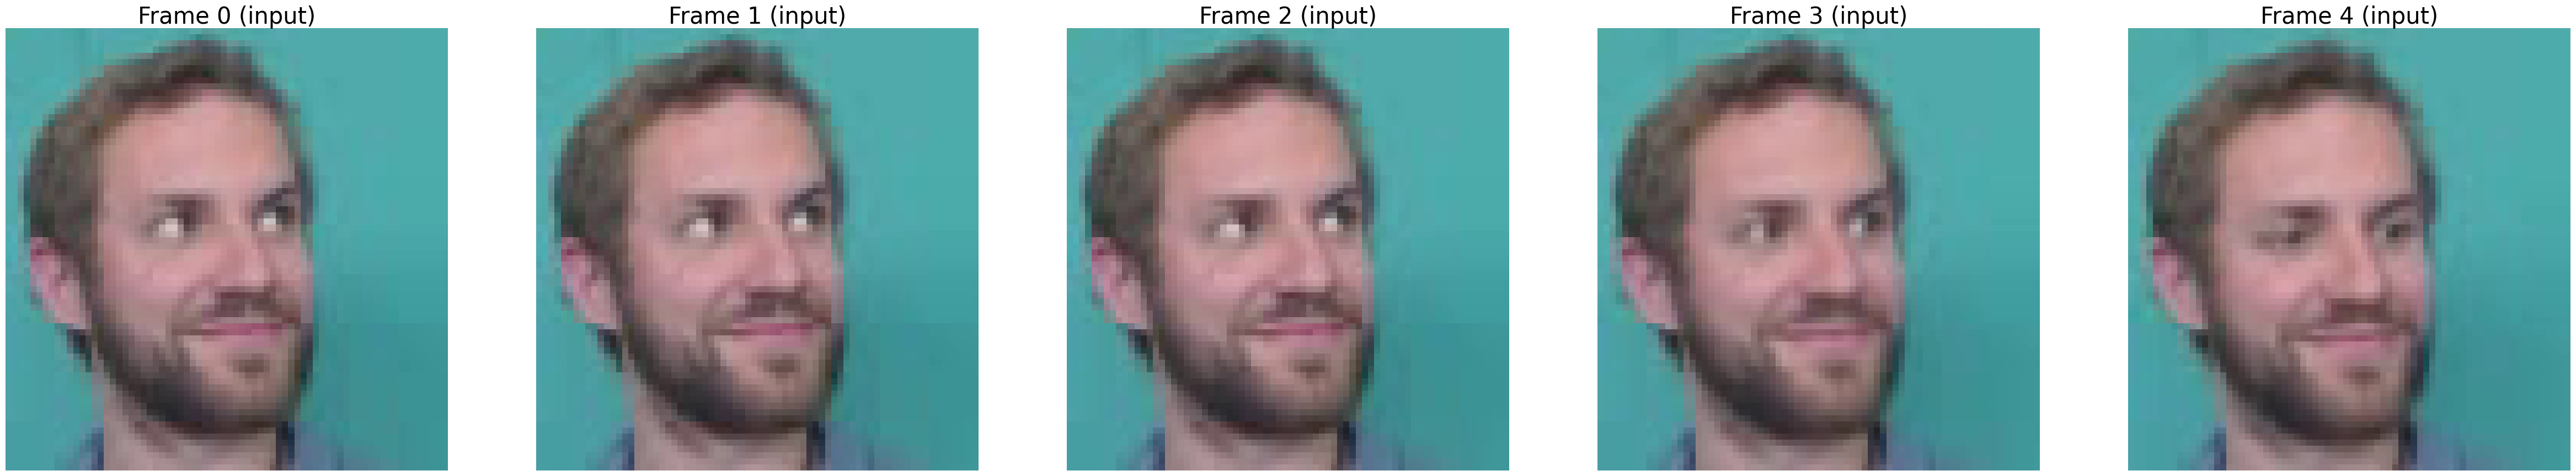

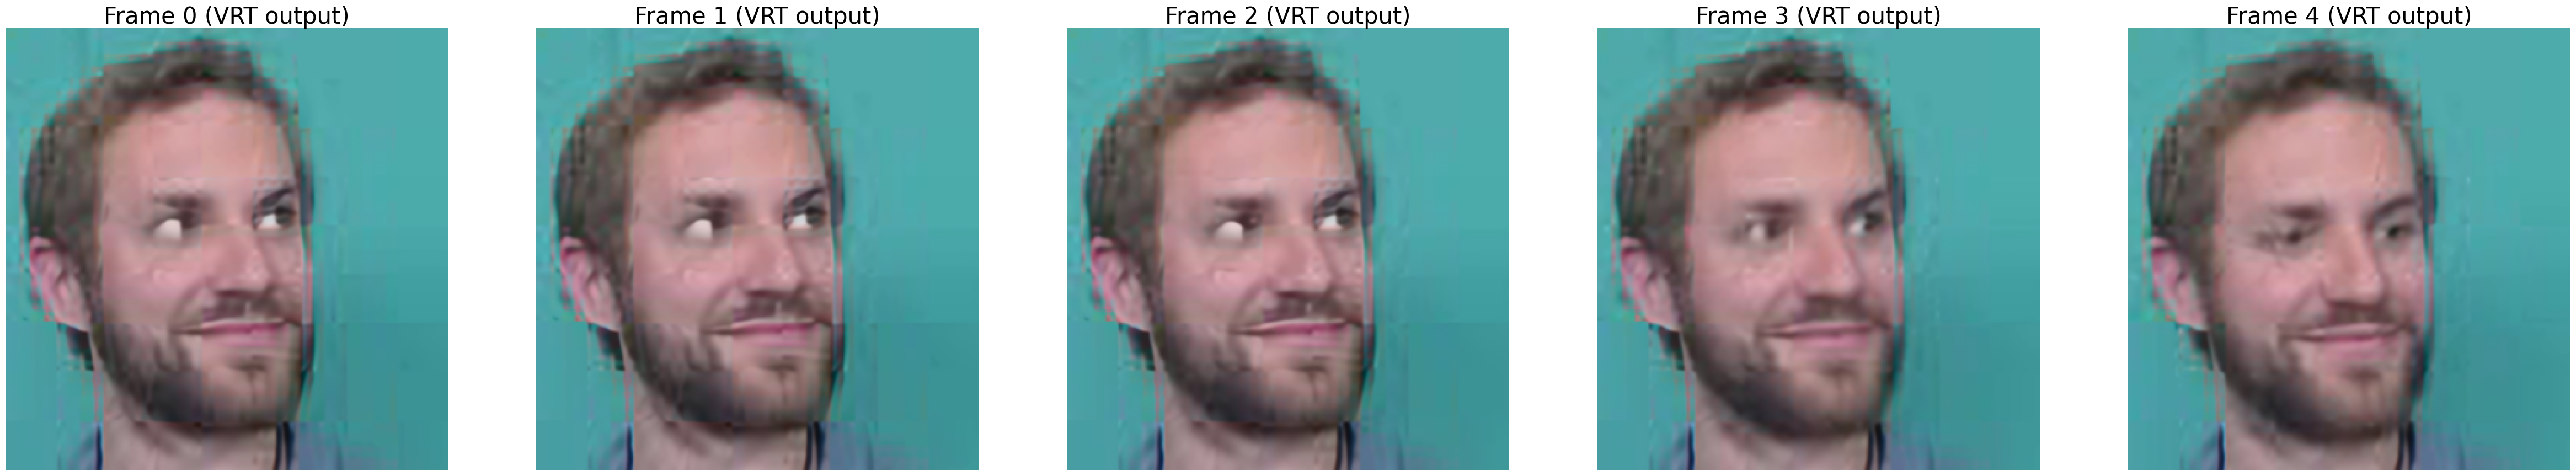

In [74]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def display(img1, name='input'):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title(f'Frame 0 ({name})', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title(f'Frame 1 ({name})', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title(f'Frame 2 ({name})', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title(f'Frame 3 ({name})', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title(f'Frame 4 ({name})', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1[0])
  ax2.imshow(img1[1])
  ax3.imshow(img1[2])
  ax4.imshow(img1[3])
  ax5.imshow(img1[4])

# display video by frames
print(' Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. \n Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.\n')

img = []
for path in sorted(Path('testsets').rglob('*.png'))[:10]:
  !ls -l $path
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'input')
img = []
for path in sorted(Path('results').rglob('*.png'))[:10]:
  !ls -l $path
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'VRT output')

In [75]:
import cv2
import os

def png_to_mp4(image_folder, output_path, fps=30, width=72, height=72):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    if not images:
        print("No PNG images found in the specified folder.")
        return

    first_image = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = first_image.shape
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in sorted(images):
        video_path = os.path.join(image_folder, image)
        frame = cv2.imread(video_path)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()
    print(f"Video saved as {output_path} successfully")

# 5. Download Results


In [76]:
RESULTS_PATH = '/content/VRT/results/005_VRT_videodeblurring_DVD/000' # @param {type: "string"}
#!ls -l $RESULTS_PATH
OUTPUT_PATH = "/content/drive/MyDrive/research_project/data/deblurred/DATASET_150_1_test" # @param {type: "string"}
WIDTH= 72 # @param {type: "number"}
HEIGHT= 72 # @param {type: "number"}
FPS= 30 # @param {type: "number"}
#!ls -l os.path.join(OUTPUT_PATH, SUBJECT)
if not os.path.isdir(os.path.join(OUTPUT_PATH, SUBJECT)):
  os.mkdir(os.path.join(OUTPUT_PATH, SUBJECT))
png_to_mp4(image_folder=RESULTS_PATH, output_path=os.path.join(OUTPUT_PATH, SUBJECT, FILE_NAME), fps=FPS, width=WIDTH, height=HEIGHT)
!ls -l $OUTPUT_PATH

Video saved as /content/drive/MyDrive/research_project/data/upscaled/DATASET_150_1_test/subject12/vid.mp4 successfully
total 12
drwx------ 2 root root 4096 Mar  8 05:29 subject10
drwx------ 2 root root 4096 Mar  8 05:46 subject11
drwx------ 2 root root 4096 Mar  8 08:20 subject12


In [77]:
!pip install -q mediapy
import mediapy as media

video1 = media.read_video(os.path.join(SOURCE_PATH, SUBJECT, FILE_NAME))
video2 = media.read_video(os.path.join(OUTPUT_PATH, SUBJECT, FILE_NAME))
videos = {'Origina;': video1, 'Deblurred/Denoised/Upscaled': video2}
media.show_videos(videos, fps=30)